In [2]:
!pip install mediapipe opencv-python


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\letyp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install pyserial


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\letyp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install pyfirmata


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\letyp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [95]:
import mediapipe as mp
import cv2
import numpy as np
import math
import serial
import time
import socket

In [104]:
# arduino = serial.Serial(port='COM5', baudrate=115200)
# time.sleep(2)
ESP_IP = "172.20.10.6"  # IP ESP32
ESP_PORT = 8266

In [105]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

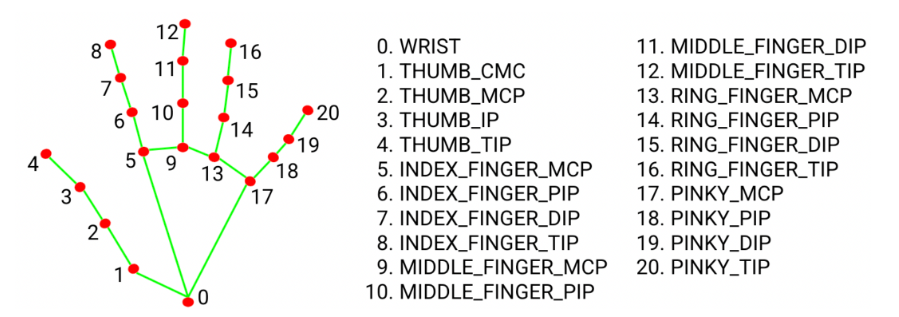

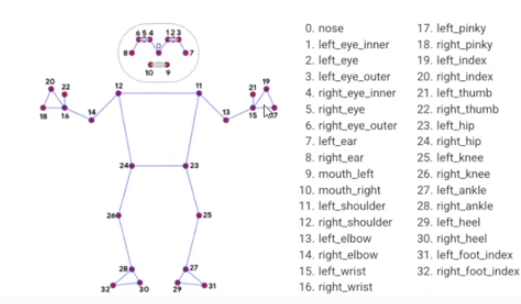

In [106]:
def connect_to_esp():
    """Быстрое подключение к ESP32 с отключением задержек TCP"""
    while True:
        try:
            sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            sock.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1)  # Отключаем задержку Nagle
            sock.settimeout(2)  # Тайм-аут на подключение (2 сек)
            sock.connect((ESP_IP, ESP_PORT))
            print(f"[INFO] Подключено к ESP32 ({ESP_IP}:{ESP_PORT})")
            return sock  # Возвращаем подключение
        except (socket.error, ConnectionRefusedError) as e:
            print(f"[ERROR] Ошибка подключения: {e}, повтор через 1 секунду...")
            time.sleep(1)  # Быстрое повторное подключение

sock = connect_to_esp()

def send_data(angles):
    """Отправка данных с обработкой ошибок и быстрой реконнекцией"""
    global sock
    message = ",".join(map(str, angles)) + "\n"

    try:
        sock.sendall(message.encode())  # Отправка данных без задержек
        print(f"[INFO] Отправлено: {message}")
    except (socket.error, BrokenPipeError, ConnectionResetError) as e:
        print(f"[ERROR] Соединение потеряно: {e}, переподключение...")
        sock.close()  # Закрываем старое соединение
        sock = connect_to_esp()  # Переподключаемся быстро
        send_data(angles)  # Повторяем отправку сразу

def calculate_angle(a, b, c):
    #переводим в нампай массивы для вычисления
    a = np.array(a) #первая точка
    b = np.array(b) #средняя точка
    c = np.array(c) #последняя точка

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0]) #вычисляем радианы 
    angle = np.abs(radians*180.0/np.pi) #угол

    #ограничим угол до 180
    if angle > 180.0:
        angle = 360-angle
    
    return angle

def euclidean_distance(p1, p2):
    return math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)



[INFO] Подключено к ESP32 (172.20.10.6:8266)


In [99]:
# def send_angles(angle_list):
#     try:
#         arduino.write(bytes(angle_list))
#         print("Отправлено:", angle_list)
#     except Exception as e:
#         print("Ошибка по записи", e)



In [107]:
prev_fist = None
prev_shoulder = None
prev_elbow = None
angle_fist = 0



try:
    # if not arduino.isOpen():
    #     arduino.open()
    # Получаем видео-поток
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # Очистка буфера перед чтением кадра

    Closed = 0
    # Открываем готовую модель
    with mp_holistic.Holistic(min_detection_confidence=0.6, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break 
                
            frame = cv2.resize(frame, (0,0), None, 2, 2)
            
            # Преобразование в RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            
            # Обратно в BGR для рендера
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # если есть обнаружение - рисуем правую руку
            if results.right_hand_landmarks:
                Closed = 0
                angle_fist = 0
                mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                
                hand_landmarks = results.right_hand_landmarks.landmark
                #cчитаем дистанцию
                distance_0_5 = euclidean_distance(hand_landmarks[0], hand_landmarks[5])
                distance_0_8 = euclidean_distance(hand_landmarks[0], hand_landmarks[8])
                distance_good = distance_0_5 + (distance_0_5/2)
                if distance_0_8 < distance_good:
                    Closed = 1
                    angle_fist = 60
                #добавляем текст на ладонь
                cv2.putText(image, str(Closed),
                            (int(hand_landmarks[0].x * image.shape[1]), int(hand_landmarks[0].y * image.shape[0])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
                
            # Рисуем правое запястье, локоть, плечо и левое плечо, соединяем их линиями
            if results.pose_landmarks:
                
                pose_landmarks = results.pose_landmarks.landmark
                #параллельно беру коорды еще и для вычисления (костыль) тут просто с названиями проще
                lshoulder = [pose_landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER.value].x,pose_landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [pose_landmarks[mp_holistic.PoseLandmark.RIGHT_ELBOW.value].x,pose_landmarks[mp_holistic.PoseLandmark.RIGHT_ELBOW.value].y]
                wrist = [pose_landmarks[mp_holistic.PoseLandmark.RIGHT_WRIST.value].x,pose_landmarks[mp_holistic.PoseLandmark.RIGHT_WRIST.value].y]
                rshoulder = [pose_landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER.value].x,pose_landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER.value].y]
                #считаем углы + рисуем
                angle_elbow = calculate_angle(rshoulder, elbow, wrist)
                angle_shoulder = calculate_angle(lshoulder, rshoulder, elbow)

                cv2.putText(image, str(angle_elbow),
                            tuple(np.multiply(elbow, [image.shape[0], image.shape[1]]).astype(int)), # подгоняем под размер изображения
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                                            
                cv2.putText(image, str(angle_shoulder),
                            tuple(np.multiply(rshoulder, [image.shape[0], image.shape[1]]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                



                #cписок нужных нам точек
                keypoints = [
                    mp_holistic.PoseLandmark.RIGHT_WRIST,
                    mp_holistic.PoseLandmark.RIGHT_ELBOW,
                    mp_holistic.PoseLandmark.RIGHT_SHOULDER,
                    mp_holistic.PoseLandmark.LEFT_SHOULDER
                ]
                points = []
                #извлекаем коорды 
                for landmark_idx in keypoints: # перебираем все нужные точки
                    landmark = pose_landmarks[landmark_idx]#получаем обьект по индексу точки (где pose_landmark - cписок всех точек тела, мы берем нужные)
                    h, w, _ = image.shape
                    cx, cy= int(landmark.x * w), int(landmark.y * h) # умножаем на ширину и высоту тк x и y находятся в диапазоне 0-1
                    points.append((cx, cy)) #каждая точка в массив
                    cv2.circle(image, (cx, cy), 5, (0, 255, 0), -1)
                    #print(points)
                # Соединяем точки линиями
                for i in range(len(points) - 1):
                    cv2.line(image, points[i], points[i + 1], (0, 255, 0), 2)
            

            # Отображение результата
            cv2.imshow('NeuroHand', image)
            
            
            if angle_fist != prev_fist or abs(angle_shoulder - prev_shoulder) > 10 or abs(angle_elbow - prev_elbow) > 10:
                 #angle_shoulder, angle_elbow,
                angles = [angle_fist, int(angle_elbow), int(angle_shoulder)]
                send_data(angles)
                prev_fist = angle_fist
                prev_shoulder = angle_shoulder
                prev_elbow = angle_elbow
                #map_value(int(angle_shoulder), 0, 45, 0, 180)

                
            
            
            




            
            time.sleep(0.070)
              
            
            
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()
except Exception as er:
    print(er)

[INFO] Отправлено: 0,156,120

[INFO] Отправлено: 0,131,121

[INFO] Отправлено: 0,160,119

[INFO] Отправлено: 0,136,117

[INFO] Отправлено: 0,124,118

[INFO] Отправлено: 0,138,116

[INFO] Отправлено: 0,67,120

[INFO] Отправлено: 0,20,107

[INFO] Отправлено: 0,88,97

[INFO] Отправлено: 0,74,96

[INFO] Отправлено: 0,60,99

[INFO] Отправлено: 0,44,100

[INFO] Отправлено: 0,60,98

[INFO] Отправлено: 0,61,108

[INFO] Отправлено: 0,67,121

[INFO] Отправлено: 0,82,127

[INFO] Отправлено: 0,109,135

[INFO] Отправлено: 0,121,134

[INFO] Отправлено: 0,134,133

[INFO] Отправлено: 60,136,131

[INFO] Отправлено: 0,132,131

[INFO] Отправлено: 0,118,141

[INFO] Отправлено: 0,115,156

[INFO] Отправлено: 0,111,132

[INFO] Отправлено: 0,106,117

[INFO] Отправлено: 0,94,112

[INFO] Отправлено: 0,80,115

[INFO] Отправлено: 0,68,112

[INFO] Отправлено: 60,65,116

[INFO] Отправлено: 0,70,118

[INFO] Отправлено: 60,71,121

[INFO] Отправлено: 0,105,118

[INFO] Отправлено: 0,123,118

[INFO] Отправлено: 60,127,1

In [14]:
import socket
import time

ESP_IP = "172.31.124.244"  # IP ESP32
ESP_PORT = 8266

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect((ESP_IP, ESP_PORT))

def send_data(data):
    message = ",".join(map(str, data)) + "\n"  # Форматируем массив в строку
    sock.sendall(message.encode())
    print(f"Отправлено: {message}")

while True:
    numbers = [30, 90, 150]  # Отправляем массив углов
    send_data(numbers)
    time.sleep(2)  # Отправляем раз в 2 секунды

Отправлено: 30,90,150

Отправлено: 30,90,150

Отправлено: 30,90,150



KeyboardInterrupt: 